<a href="https://colab.research.google.com/github/KennethC12/Sign-Language-MNIST/blob/main/Sign_Language.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
from tensorflow.keras.utils import to_categorical

In [3]:
train = pd.read_csv("sign_mnist_train.csv")
test = pd.read_csv("sign_mnist_test.csv")

In [8]:
# Separate pixels/labels
X_train = train.drop(columns=["label"]).values.astype("float32") / 255.0
y_train_raw = train["label"].values

X_test  = test.drop(columns=["label"]).values.astype("float32") / 255.0
y_test_raw  = test["label"].values

# Reshape to images (N, 28, 28, 1)
X_train = X_train.reshape(-1, 28, 28, 1)
X_test  = X_test.reshape(-1, 28, 28, 1)

# Remap labels to contiguous 0..23 (because J and Z are missing)
unique_labels = np.unique(y_train_raw)
label_to_compact = {lab:i for i, lab in enumerate(sorted(unique_labels))}
num_classes = len(unique_labels)   # should be 24

y_train = np.vectorize(label_to_compact.get)(y_train_raw)
y_test  = np.vectorize(label_to_compact.get)(y_test_raw)

y_train = to_categorical(y_train, num_classes=num_classes)
y_test  = to_categorical(y_test,  num_classes=num_classes)

print("Shapes:", X_train.shape, y_train.shape, X_test.shape, y_test.shape, "num_classes=", num_classes)


Shapes: (27455, 28, 28, 1) (27455, 24) (7172, 28, 28, 1) (7172, 24) num_classes= 24


In [10]:
import tensorflow as tf
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense

model = Sequential([
    Input(shape=(28, 28, 1)),
    Conv2D(32, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 26, 26, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 11, 11, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 3, 3, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 24)             │         6,168 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,760 (518.59 KB)

 Trainable params: 132,312 (516.84 KB)

 Non-trainable params: 448 (1.75 KB)

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)
datagen.fit(X_train)

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
]

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=64, shuffle=True),
    validation_data=(X_test, y_test),
    epochs=20,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/20
429/429 ━━━━━━━━━━━━━━━━━━━━ 51s 110ms/step - accuracy: 0.4380 - loss: 1.8991 - val_accuracy: 0.6672 - val_loss: 1.1362 - learning_rate: 0.0010
Epoch 2/20
429/429 ━━━━━━━━━━━━━━━━━━━━ 52s 122ms/step - accuracy: 0.9005 - loss: 0.3098 - val_accuracy: 0.9020 - val_loss: 0.2988 - learning_rate: 0.0010
Epoch 3/20
429/429 ━━━━━━━━━━━━━━━━━━━━ 46s 107ms/step - accuracy: 0.9438 - loss: 0.1677 - val_accuracy: 0.9253 - val_loss: 0.2416 - learning_rate: 0.0010
Epoch 4/20
429/429 ━━━━━━━━━━━━━━━━━━━━ 47s 110ms/step - accuracy: 0.9643 - loss: 0.1100 - val_accuracy: 0.9446 - val_loss: 0.1725 - learning_rate: 0.0010
Epoch 5/20
429/429 ━━━━━━━━━━━━━━━━━━━━ 46s 107ms/step - accuracy: 0.9728 - loss: 0.0872 - val_accuracy: 0.9773 - val_loss: 0.0815 - learning_rate: 0.0010
Epoch 6/20
429/429 ━━━━━━━━━━━━━━━━━━━━ 47s 109ms/step - accuracy: 0.9777 - loss: 0.0719 - val_accuracy: 0.9636 - val_loss: 0.0923 - learning_rate: 0.0010
Epoch 7/20
429/429 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.98

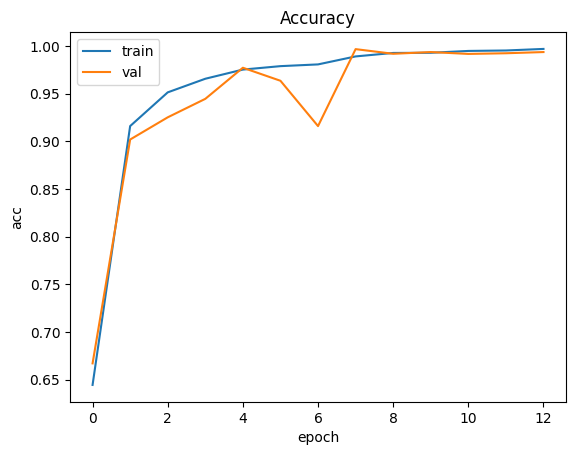

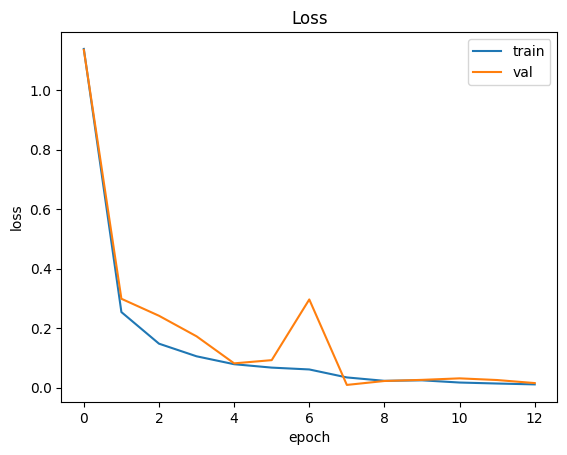

In [13]:
import matplotlib.pyplot as plt
h = history.history
plt.figure(); plt.plot(h['accuracy']); plt.plot(h['val_accuracy']); plt.title('Accuracy'); plt.xlabel('epoch'); plt.ylabel('acc'); plt.legend(['train','val'])
plt.figure(); plt.plot(h['loss']); plt.plot(h['val_loss']); plt.title('Loss'); plt.xlabel('epoch'); plt.ylabel('loss'); plt.legend(['train','val'])
plt.show()


In [14]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test accuracy: {test_acc:.4f}  |  Test loss: {test_loss:.4f}")

y_pred = np.argmax(model.predict(X_test, verbose=0), axis=1)
y_true = np.argmax(y_test, axis=1)
print(classification_report(y_true, y_pred))
cm = confusion_matrix(y_true, y_pred)
cm[:5,:5]  # peek


Test accuracy: 0.9968  |  Test loss: 0.0090
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       331
           1       1.00      1.00      1.00       432
           2       1.00      1.00      1.00       310
           3       1.00      1.00      1.00       245
           4       1.00      1.00      1.00       498
           5       1.00      1.00      1.00       247
           6       1.00      1.00      1.00       348
           7       1.00      1.00      1.00       436
           8       1.00      1.00      1.00       288
           9       1.00      1.00      1.00       331
          10       1.00      1.00      1.00       209
          11       1.00      1.00      1.00       394
          12       1.00      0.99      1.00       291
          13       1.00      1.00      1.00       246
          14       1.00      1.00      1.00       347
          15       1.00      1.00      1.00       164
          16       1.00      1.00    

array([[331,   0,   0,   0,   0],
       [  0, 432,   0,   0,   0],
       [  0,   0, 310,   0,   0],
       [  0,   0,   0, 245,   0],
       [  0,   0,   0,   0, 497]])

In [15]:
# Reuse the mapping you built earlier:
# unique_labels, label_to_compact
compact_to_label = {v:k for k,v in label_to_compact.items()}

# Map compact ids to letters (A..Z minus J & Z)
letters = [chr(ord('A') + i) for i in range(26)]
letters.remove('J')
letters.remove('Z')

# Sanity check: make sure ordering matches your compact mapping
id_to_letter = {i: letters[i] for i in range(len(letters))}


In [16]:
import json, os

os.makedirs("artifacts", exist_ok=True)
model.save("artifacts/asl_cnn.keras")

with open("artifacts/label_map.json", "w") as f:
    json.dump({"label_to_compact": {int(k): int(v) for k,v in label_to_compact.items()}}, f)


In [17]:
def predict_tta(x, n=5):
    import tensorflow as tf
    preds = []
    for _ in range(n):
        x_aug = tf.image.random_flip_left_right(x)  # hands may flip meaninglessly on this dataset; if flip hurts, remove it
        x_aug = tf.image.random_brightness(x_aug, 0.05)
        preds.append(model.predict(x_aug, verbose=0))
    return np.mean(preds, axis=0)


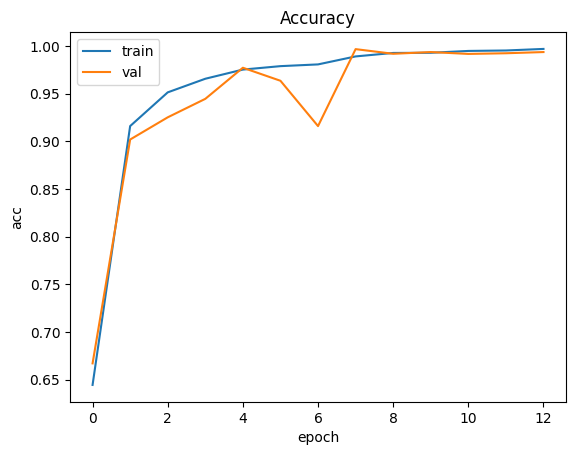

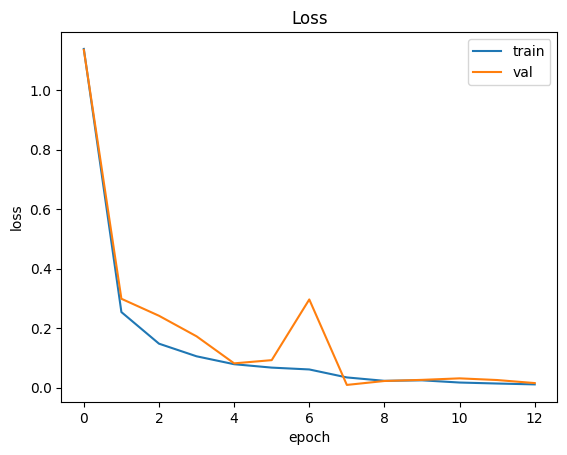

In [18]:
import matplotlib.pyplot as plt
h = history.history
plt.figure(); plt.plot(h['accuracy']); plt.plot(h['val_accuracy']); plt.title('Accuracy'); plt.xlabel('epoch'); plt.ylabel('acc'); plt.legend(['train','val'])
plt.figure(); plt.plot(h['loss']); plt.plot(h['val_loss']); plt.title('Loss'); plt.xlabel('epoch'); plt.ylabel('loss'); plt.legend(['train','val'])
plt.show()
